In [1]:
import pandas as pd
import torch
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import numpy as np
import karman
from karman.nn import *
import os
from torch.utils.data import Subset
from torch import nn
import argparse
from pyfiglet import Figlet
from termcolor import colored
from dataclasses import dataclass
from matplotlib import pyplot as plt
import imageio
from PIL import Image
import io
from IPython.display import Image
from astropy.time import Time
import astropy

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
@dataclass
class Opt():
    pass

In [6]:
print('Karman Model Evaluation')

f = Figlet(font='5lineoblique')
print(colored(f.renderText('KARMAN'), 'red'))

f = Figlet(font='digital')
print(colored(f.renderText("Thermospheric  density  calculations"), 'blue'))
print(colored(f'Version {karman.__version__}\n','blue'))

opt = Opt()
opt.model_name = 'no_lag'
opt.model_folder = '/home/jupyter/karman-project/cyclical_features_again'
opt.batch_size = 512
opt.num_workers = 30
opt.data_directory = '/home/jupyter/karman-project/data_directory'

#Stick to this convention 'best_model' is the model of interest.
model_path = [os.path.join(opt.model_folder, f) for f in os.listdir(opt.model_folder) if 'best_model' in f][0]

print('Loading Data')
model_opt=torch.load(model_path)['opt']

dataset = karman.ThermosphericDensityDataset(
    directory=opt.data_directory,
    exclude_omni=model_opt.exclude_omni,
    exclude_fism2_daily=model_opt.exclude_fism2_daily,
    exclude_fism2_flare=model_opt.exclude_fism2_flare,
    lag_minutes_omni=model_opt.lag_minutes_omni,
    lag_days_fism2_daily=model_opt.lag_days_fism2_daily,
    lag_minutes_fism2_flare=model_opt.lag_minutes_fism2_flare,
    wavelength_bands_to_skip=model_opt.wavelength_bands_to_skip,
    omniweb_downsampling_ratio=model_opt.omniweb_downsampling_ratio,
    features_to_exclude_omni=model_opt.features_to_exclude_omni,
    features_to_exclude_thermo=model_opt.features_to_exclude_thermo,
    features_to_exclude_fism2_flare=model_opt.features_to_exclude_fism2_flare,
    features_to_exclude_fism2_daily=model_opt.features_to_exclude_fism2_daily
)

print('Loading Model')

if model_opt.model == 'FeedForwardDensityPredictor':
    # Will only use an FFNN with just the thermo static features data
    model = FeedForwardDensityPredictor(
                        num_features=dataset.data_thermo_matrix.shape[1]
                        )
elif model_opt.model=='Fism2FlareDensityPredictor':
    if model_opt.exclude_fism2_daily and model_opt.exclude_omni:
        model=Fism2FlareDensityPredictor(
                        input_size_thermo=dataset.data_thermo_matrix.shape[1],
                        input_size_fism2_flare=dataset.fism2_flare_irradiance_matrix.shape[1],
                        output_size_fism2_flare=20
                        )
    else:
        raise RuntimeError(f"exclude_fism2_daily and exclude_omni are not set to True; while model chosen is {model_opt.model}")
elif model_opt.model=='Fism2DailyDensityPredictor':
    if model_opt.exclude_fism2_flare and model_opt.exclude_omni:
        model=Fism2DailyDensityPredictor(
                        input_size_thermo=dataset.data_thermo_matrix.shape[1],
                        input_size_fism2_daily=dataset.fism2_daily_irradiance_matrix.shape[1],
                        output_size_fism2_daily=20
                        )
    else:
        raise RuntimeError(f"exclude_fism2_flare and exclude_omni are not set to True; while model chosen is {model_opt.model}")
elif model_opt.model=='OmniDensityPredictor':
    if model_opt.exclude_fism2_daily and model_opt.exclude_fism2_flare:
        model=OmniDensityPredictor(
                        input_size_thermo=dataset.data_thermo_matrix.shape[1],
                        input_size_omni=dataset.data_omni_matrix.shape[1],
                        output_size_omni=20
                        )
    else:
        raise RuntimeError(f"exclude_fism2_daily and exclude_fism2_flare are not set to True; while model chosen is {model_opt.model}")
elif model_opt.model == 'FullFeatureDensityPredictor':
    if model_opt.exclude_omni==False and model_opt.exclude_fism2_flare==False and model_opt.exclude_fism2_daily==False:
        model = FullFeatureDensityPredictor(
                        input_size_thermo=dataset.data_thermo_matrix.shape[1],
                        input_size_fism2_flare=dataset.fism2_flare_irradiance_matrix.shape[1],
                        input_size_fism2_daily=dataset.fism2_daily_irradiance_matrix.shape[1],
                        input_size_omni=dataset.data_omni_matrix.shape[1],
                        output_size_fism2_flare=20,
                        output_size_fism2_daily=20,
                        output_size_omni=20
                        )
state_dict = torch.load(os.path.join(model_path))['state_dict']
#Sanitize state_dict key names
for key in list(state_dict.keys()):
    if key.startswith('module'):
    # Model was saved as dataparallel model
        # Remove 'module.' from start of key
        state_dict[key[7:]] = state_dict.pop(key)
    else:
        continue
model.load_state_dict(state_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Karman Model Evaluation
                                                                         
                                                                         
    //   / /   // | |     //   ) )  /|    //| |     // | |     /|    / / 
   //__ / /   //__| |    //___/ /  //|   // | |    //__| |    //|   / /  
  //__  /    / ___  |   / ___ (   // |  //  | |   / ___  |   // |  / /   
 //   \ \   //    | |  //   | |  //  | //   | |  //    | |  //  | / /    
//     \ \ //     | | //    | | //   |//    | | //     | | //   |/ /     

+-+-+-+-+-+-+-+-+-+-+-+-+-+  +-+-+-+-+-+-+-+  +-+-+-+-+-+-+-+-+-+-+-+-+
|T|h|e|r|m|o|s|p|h|e|r|i|c|  |d|e|n|s|i|t|y|  |c|a|l|c|u|l|a|t|i|o|n|s|
+-+-+-+-+-+-+-+-+-+-+-+-+-+  +-+-+-+-+-+-+-+  +-+-+-+-+-+-+-+-+-+-+-+-+

Version 0.0.1

Loading Data
Loading Thermospheric Density Dataset:
Creating cyclical features

Normalizing data:

Normalizing thermospheric data, features: ['all__day_of_year__[d]', 'all__year__[y]', 'all__seconds_in_day__[s]', 'tudelft_the

FeedForwardDensityPredictor(
  (ffnn): FFNN(
    (fc1): Sequential(
      (0): Linear(in_features=34, out_features=100, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Dropout(p=0.0, inplace=False)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=100, out_features=100, bias=True)
      (7): LeakyReLU(negative_slope=0.01)
      (8): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

In [7]:
with open(os.path.join(opt.data_directory, "test_indices.txt"), 'r') as f:
    test_indices = [int(line.rstrip()) for line in f]

In [8]:
dataset.data_thermo.loc[dataset.index_list[test_indices[0]]]

all__day_of_year__[d]                                                           25.0
all__year__[y]                                                                2008.0
all__seconds_in_day__[s]                                                     32116.0
tudelft_thermo__altitude__[m]                                             346195.375
tudelft_thermo__longitude__[deg]                                           48.055599
tudelft_thermo__latitude__[deg]                                            85.012749
tudelft_thermo__local_solar_time__[h]                                      12.124818
space_environment_technologies__f107_average__                                  73.0
space_environment_technologies__f107_obs__                                 71.300003
celestrack__ap_average__                                                        10.0
celestrack__ap_h_0__                                                            10.0
celestrack__ap_h_1__                                             

In [10]:
batch = dataset.__getitem__(test_indices[0])
for key in batch.keys():
    batch[key] = batch[key].unsqueeze(0)
    batch[key] = batch[key].to(device)

In [11]:
dataset.thermo_mins

{'JB08__d_st_dt__[K]': 0.0,
 'all__day_of_year__[d]_cos': -0.999963,
 'all__day_of_year__[d]_sin': -0.99999076,
 'all__seconds_in_day__[s]_cos': -0.99999994,
 'all__seconds_in_day__[s]_sin': -1.0,
 'all__sidereal_time__[rad]_cos': -1.0,
 'all__sidereal_time__[rad]_sin': -1.0,
 'all__sun_declination__[rad]_cos': 0.9174831,
 'all__sun_declination__[rad]_sin': -0.39777473,
 'all__sun_right_ascension__[rad]_cos': -1.0,
 'all__sun_right_ascension__[rad]_sin': -1.0,
 'all__year__[y]': 2001.0,
 'celestrack__ap_average__': 0.0,
 'celestrack__ap_h_0__': 0.0,
 'celestrack__ap_h_1__': 0.0,
 'celestrack__ap_h_2__': 0.0,
 'celestrack__ap_h_3__': 0.0,
 'celestrack__ap_h_4__': 0.0,
 'celestrack__ap_h_5__': 0.0,
 'celestrack__ap_h_6__': 0.0,
 'space_environment_technologies__f107_average__': 65.8,
 'space_environment_technologies__f107_obs__': 64.0,
 'space_environment_technologies__m107_average__': 61.9,
 'space_environment_technologies__m107_obs__': 60.0,
 'space_environment_technologies__s107_avera

100%|██████████| 7/7 [02:41<00:00, 23.01s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


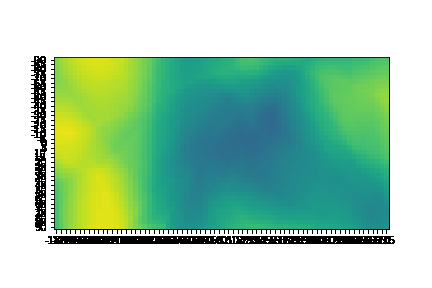

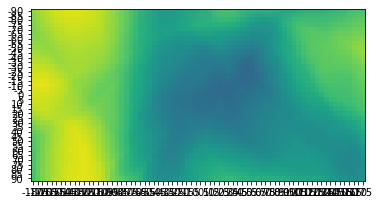

In [98]:
images = []
lon_step = 5
lat_step = 5
lon_range = range(-180,180,lon_step)
lat_range = range(-90,90+lat_step,lat_step)
altitude = 0.6

time_and_position_based_features_to_calculate = [
    'all__day_of_year__[d]',
    'all__seconds_in_day__[s]',
    'all__sun_right_ascension__[rad]',
    'all__sun_declination__[rad]',
    'all__sidereal_time__[rad]',
    'tudelft_thermo__longitude__[deg]',
    'tudelft_thermo__latitude__[deg]'
    'tudelft_thermo__local_solar_time__[h]']

def create_datapoint(date, longitude, latitude):
    sample = {}
    date = pd.to_datetime(date)
    second_in_day = 3600*date.hour + 60*date.minute + date.second
    day_of_year = date.day_of_year
    t=Time(str(date),location=(f'{longitude}d', f'{latitude}d'))
    sunpos=astropy.coordinates.get_sun(t)
    sun_ra = sunpos.ra.rad
    sun_dec = sunpos.dec.rad
    side_real = t.sidereal_time('mean').rad
    lst = (second_in_day/3600.0 + longitude/15.)

    sample['all__seconds_in_day__[s]_sin'] = np.sin(2*np.pi*second_in_day/(24.0*60*60))
    sample['all__seconds_in_day__[s]_cos'] = np.cos(2*np.pi*second_in_day/(24.0*60*60))

    sample['all__day_of_year__[d]_sin'] = np.sin(2*np.pi*day_of_year/366.0)
    sample['all__day_of_year__[d]_cos'] = np.cos(2*np.pi*day_of_year/366.0)

    sample['all__sun_right_ascension__[rad]_sin'] = np.sin(sun_ra)
    sample['all__sun_right_ascension__[rad]_cos'] = np.cos(sun_ra)

    sample['all__sun_declination__[rad]_sin'] = np.sin(sun_dec)
    sample['all__sun_declination__[rad]_cos'] = np.cos(sun_dec)

    sample['all__sidereal_time__[rad]_sin'] = np.sin(side_real)
    sample['all__sidereal_time__[rad]_cos'] = np.cos(side_real)

    sample['tudelft_thermo__local_solar_time__[h]_sin'] = np.sin(2*np.pi*((lst + 12.0)/48))
    sample['tudelft_thermo__local_solar_time__[h]_cos'] = np.cos(2*np.pi*((lst + 12.0)/48))

    sample['tudelft_thermo__latitude__[deg]'] = float(latitude)

    sample['tudelft_thermo__longitude__[deg]_sin'] = np.sin(2*np.pi*((longitude + 180)/360.0))
    sample['tudelft_thermo__longitude__[deg]_cos'] = np.cos(2*np.pi*((longitude + 180)/360.0))

    sample['all__year__[y]'] = float(date.year)
    return sample

def normalize_datapoint(datapoint, dataset):
    normalized = {}
    for feature in datapoint.keys():
        normalized[feature] = dataset.minmax_normalize(
            datapoint[feature],
            dataset.thermo_mins[feature],
            dataset.thermo_maxs[feature]
        )
    constant_features = list(set(dataset.thermo_features) - set(datapoint.keys()))
    for feature in constant_features:
        normalized[feature] = 0.5

    return normalized

images = []
for date in tqdm(pd.date_range(start='2011-01-01 00:00:00', end='2011-01-02 00:00:00', freq='240T')):
    thermo_map = np.zeros((len(lat_range), len(lon_range)))
    for longitude in lon_range:
        new_batch = {}
        new_batch['static_features'] = torch.cat(len(lat_range)*[batch['static_features']])
        for key in batch.keys():
            if key != 'static_features':
                new_batch[key] = torch.cat(len(lat_range)*[batch[key]])

        for i, latitude in enumerate(lat_range):
            datapoint = create_datapoint(date, longitude, latitude)
            normalized_datapoint = normalize_datapoint(datapoint, dataset)
            for feature in normalized_datapoint.keys():
                new_batch['static_features'][i,dataset.thermo_features.index(feature)] = normalized_datapoint[feature]

        with torch.no_grad():
            model.eval()
            output = model.forward(new_batch)
        thermo_map[:, int((longitude+180)/lon_step)] = np.squeeze(output.detach().cpu().numpy())
    images.append(thermo_map)

min_ = np.inf
max_ = -np.inf
for image in images:
    if image.min() < min_:
        min_ = image.min()
    if image.max() > max_:
        max_ = image.max()

for i, image in enumerate(images):
    plt.imshow(image, vmin=min_, vmax=max_)
    plt.xticks(range(len(lon_range)), lon_range)
    plt.yticks(range(len(lat_range)), lat_range)
    plt.savefig('/home/jupyter/'+str(i)+'.png')

with imageio.get_writer('day.gif', mode='I', fps=2) as writer:
    for filename in ['/home/jupyter/'+str(i)+'.png' for i in range(len(images))]:
        image = imageio.imread(filename)
        writer.append_data(image)
Image(filename="day.gif")

In [101]:
batch = dataset.__getitem__(test_indices[0])
for key in batch.keys():
    batch[key] = batch[key].unsqueeze(0)
    batch[key] = batch[key].to(device)

for i, feature in enumerate(dataset.thermo_features):
    latitude = dataset.data_thermo.loc[dataset.index_list[test_indices[0]], 'tudelft_thermo__latitude__[deg]']
    longitude = dataset.data_thermo.loc[dataset.index_list[test_indices[0]], 'tudelft_thermo__longitude__[deg]']
    date = dataset.data_thermo.loc[dataset.index_list[test_indices[0]], 'all__dates_datetime__']
    datapoint = normalize_datapoint(create_datapoint(date, longitude, latitude),dataset)
    if feature in datapoint.keys():
        print(feature, datapoint[feature], batch['static_features'][0,i])

JB08__d_st_dt__[K] 0.5 tensor(0.1312, device='cuda:0')
all__day_of_year__[d]_cos 0.9546529119457022 tensor(0.9579, device='cuda:0')
all__day_of_year__[d]_sin 0.7080642702432596 tensor(0.7007, device='cuda:0')
all__seconds_in_day__[s]_cos 0.15382342213562372 tensor(0.1537, device='cuda:0')
all__seconds_in_day__[s]_sin 0.8607794306385004 tensor(0.8607, device='cuda:0')
all__sidereal_time__[rad]_cos 0.793344139117043 tensor(0.7933, device='cuda:0')
all__sidereal_time__[rad]_sin 0.0950935712467868 tensor(0.0951, device='cuda:0')
all__sun_declination__[rad]_cos 0.3326821508602022 tensor(0.3327, device='cuda:0')
all__sun_declination__[rad]_sin 0.08863909646229907 tensor(0.0886, device='cuda:0')
all__sun_right_ascension__[rad]_cos 0.8007649052291692 tensor(0.8008, device='cuda:0')
all__sun_right_ascension__[rad]_sin 0.1005748232991705 tensor(0.1006, device='cuda:0')
all__year__[y] 0.5 tensor(0.3500, device='cuda:0')
celestrack__ap_average__ 0.5 tensor(0.0490, device='cuda:0')
celestrack__ap_h

In [84]:
batch = dataset.__getitem__(test_indices[0])
for key in batch.keys():
    batch[key] = batch[key].unsqueeze(0)
    batch[key] = batch[key].to(device)

In [82]:
len(dataset.thermo_features), len(normalized_datapoint.keys())

(34, 34)

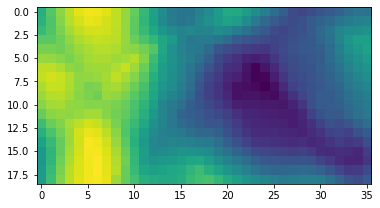

In [76]:
plt.imshow(thermo_map, vmin=thermo_map.min(), vmax=thermo_map.max())

In [60]:
outputs = []
for f107 in np.arange(0,1,0.05):
    batch['static_features'][:,7:9] = f107
    batch['static_features'][:,20:26] = f107
    outputs.append(model.forward(batch))
plt.plot(outputs)
plt.xticks(range(0,20,2), labels=[f'{int(100*i/20)}%' for i in range(0,20, 2)])
plt.title('Model Sensitivity to Linearly increasing Irradiance Proxies')
plt.xlabel('Irradiance Proxies as a percentage of their maximum')
plt.ylabel('Model density (log space)')
batch['static_features'][:,7:9] = 0.1
batch['static_features'][:,20:26] = f107

tensor([[0.2959, 0.3333, 0.5433, 0.8159, 0.3973, 0.0640, 0.4702, 0.0442, 0.0274,
         0.0245, 0.0245, 0.0200, 0.0150, 0.0100, 0.0200, 0.0351, 0.0249, 0.0761,
         0.7407, 0.0177, 0.0175, 0.0192, 0.0000, 0.0251, 0.0330, 0.0150, 0.0911]],
       device='cuda:0')